Stock Market Prediction for a Stock Ticker

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('classic')

from wfc_config import wfc_config
from wfc_ds import StockDataGather, StockDataRead, StockDataPlot
from wfc_lstm import StockLSTM
from wfc_news import wfc_feed


In [8]:
from os.path import expanduser

# Get the config
DEFAULT_CONFIG = "/.wfc"
cfgFileName = expanduser("~") + DEFAULT_CONFIG
try:
    cfgFile = open(cfgFileName, "r")
    cfgBuf = cfgFile.read()
    cfg = wfc_config(cfgBuf)
except:
    logger.error("Unable to read " + cfgFileName)

In [9]:
ticker = "ILMN"
begin_date = "10-1-2018"
end_date = "11-15-2018"
predict_date = "11-29-2018"

In [10]:
sdg = StockDataGather(ticker, begin_date, end_date)
sdg.GetStockDataSheet()
sdr = StockDataRead(ticker)
sdr.summary(predict_date)

[I 181119 14:24:58 wfc_ds:98] Already exists data/ILMN/ILMN-stock-data.csv


Data Collection 
	Start date: 2018-10-01 00:00:00
	End date: 2018-11-14 00:00:00
Data for 33 weekdays -77 weekends
Data total for -44 days
First row Day 2018-10-01 closed at 366.540009
Last row Day 2018-11-14 closed at 308.230011
Prediction day 2018-11-29 00:00:00
Last day to prediction day: 15 days
Max price: 366.540009	2018-10-01
Min price: 289.5	2018-10-24


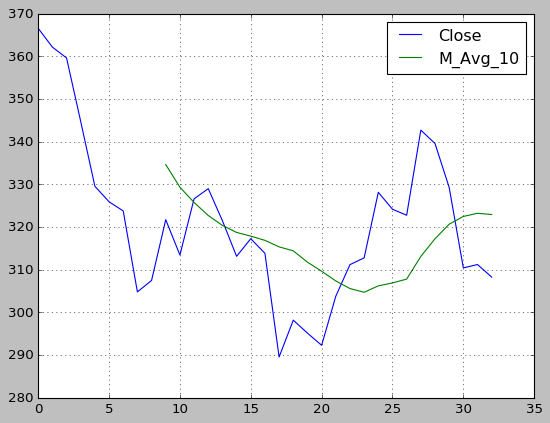

In [11]:
sdp = StockDataPlot(sdr.stock_data)
sdp.closing()

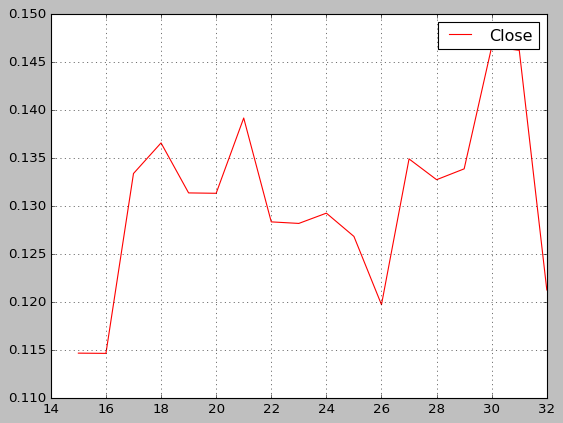

In [12]:
sdp.volatility(15)

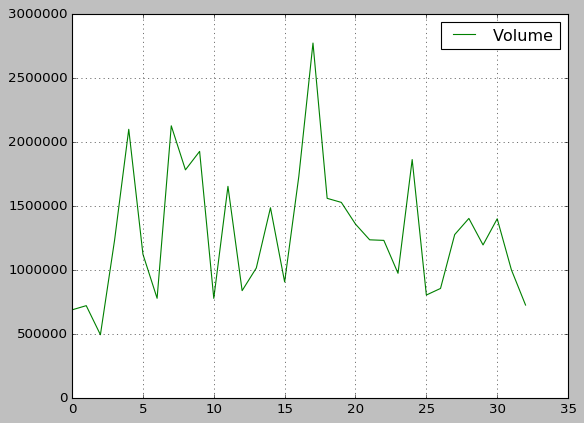

In [13]:
sdp.volume()

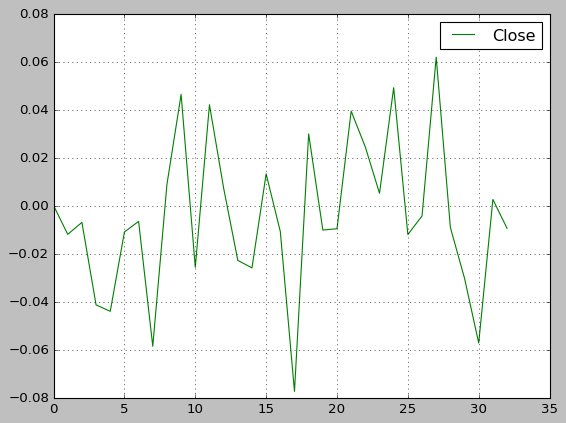

In [14]:
sdp.daily()

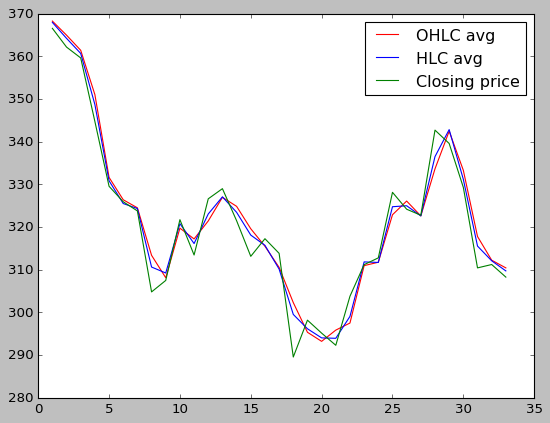

In [15]:
sl = StockLSTM(sdr.StockFileName())
plt.plot(sl.obs, sl.OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(sl.obs, sl.HLC_avg, 'b', label = 'HLC avg')
plt.plot(sl.obs, sl.close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [16]:
future_date = predict_date

sdr.analyze("linear")
pval_linear = sdr.predict(future_date)
print("linear\t" + future_date + "\t" + str(pval_linear))

sdr.analyze("svm")
pval_svm = sdr.predict(future_date)
print("svm\t" + future_date + "\t" + str(pval_svm))

sdr.analyze("randc")
pval_randc = sdr.predict(future_date)
print("randc\t" + future_date + "\t" + str(pval_randc))


linear	MAE 1.4210854715202004e-16	: mse: 8.077935669463161e-28 variance: 1.00
linear	11-29-2018	321.450012
svm	MAE 0.12484252291666657	: mse: 234.67176478248666 variance: -0.30
svm	11-29-2018	313.1029993333334
randc	MAE 0.06582496624999998	: mse: 58.025194582570776 variance: 0.68
randc	11-29-2018	326


Now let's do some analysis using LSTM and Neural Networks

In [ ]:
sl.main()

In [ ]:
# Predictions from othar Algos
print("Future Date:\t" + future_date)
print("\tlinear: " + str(pval_linear))
print("\tsvm: " + str(pval_svm))
print("\trandc: " + str(pval_randc))
pval_avg = (pval_linear+pval_svm+pval_randc)/3
print("Avg: " + str(pval_avg))

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(sl.OHLC_avg, 'g', label = 'original dataset')
plt.plot(sl.trainPredictPlot, 'r', label = 'training set')
plt.plot(sl.testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
ystr = "Value of " + ticker + " Stock"
plt.ylabel(ystr)
plt.show()


Decision Making for Buy or Sell or Hold

In [36]:
# gains and losses

if (cfg.isOwned(ticker)):
    predict_dt = datetime.strptime(predict_date, "%m-%d-%Y")
    print("Purchased\tDays\tPaid\tPredict\tGainLoss\tPercent\tTax\tPocket")
    print("==============================================================================")
    tx = cfg.owned_ticker(ticker)
    for tp in tx['ticker_purchase']:
        for dt,x in tp.items():
            purchase_date = datetime.strptime(dt, "%m-%d-%Y")
            tdelta = predict_dt - purchase_date
            purchase_amount = int(x[0] * x[1])
            predict_amount = int(x[0] * pval_avg)
            gl = predict_amount - purchase_amount
            if tdelta.days >= 365:
                taxp = 20
            else:
                taxp = 35
            if (gl < 0):
                taxv = 0
                in_pocket = gl
            else:
                taxv = int(float(gl*taxp/100))
                in_pocket = gl - taxv
            glp = int(float(gl/purchase_amount) * 100)
            print(dt + "\t" + str(tdelta.days) + "\t" + str(purchase_amount ) \
                 + "\t" + str(predict_amount) + "\t" + str(gl) + "\t\t" + str(glp) \
                  + "\t" + str(taxv) + "\t" + str(in_pocket))

Purchased	Days	Paid	Predict	GainLoss	Percent	Tax	Pocket
7-27-2017	490	9397	26092	16695		177	3339	13356
8-21-2018	100	19037	18637	-400		-2	0	-400


Let's look at some sentiments

In [37]:
nn = wfc_feed(ticker)
nn.get_news()
nn.show_summary(ticker)

SQ	+ve: 1.565	-ve: 1.111	~neutral: 15.324000000000002


News headlines

In [38]:
#nn.get_titles()